<a href="https://colab.research.google.com/github/trefftzc/cis677/blob/main/Mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

find: ‘/proc/65/task/65/net’: Invalid argument
find: ‘/proc/65/net’: Invalid argument
/root/.julia/artifacts/6283886c5dd600750885a23bff8d37f687172633/share/libdevice
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/libdevice
/usr/local/cuda-12.5/nvvm/libdevice
find: ‘/proc/65/task/65/net’: Invalid argument
find: ‘/proc/65/net’: Invalid argument
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/lib64/libnvvm.so
/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so


In [24]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"

In [25]:
!uv pip install -q --system numba-cuda==0.15

In [27]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  ".ascontiguousarray()"


Execution time: 1.347113 seconds


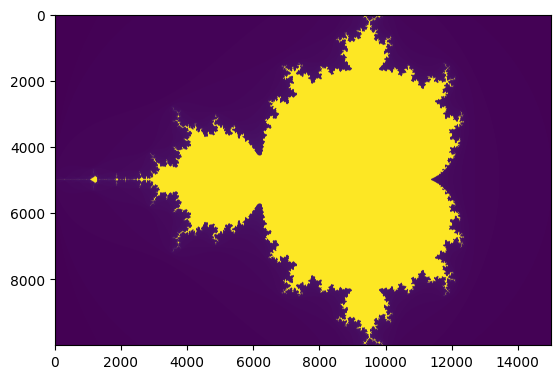

In [28]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, show
import numpy as np

from numba import cuda


@cuda.jit(device=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255


@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x[0] - min_x[0]) / width
    pixel_size_y = (max_y[0] - min_y[0]) / height

    x, y = cuda.grid(2)

    if x < width and y < height:
        real = min_x[0] + x * pixel_size_x
        imag = min_y[0] + y * pixel_size_y
        color = mandel(real, imag, iters[0])
        image[y, x] = color


width = 15000
height = 10000
image = np.zeros((height, width), dtype=np.uint32)

pixels = width * height
nthreads = 32
nblocksy = (height // nthreads) + 1
nblocksx = (width // nthreads) + 1
s = timer()
min_x=np.array([-2.0])
max_x=np.array([1.0])
min_y=np.array([-1.0])
max_y=np.array([1.0])
iters=np.array([20])
#create_fractal[(nblocksx, nblocksy), (nthreads, nthreads)](
#    -2.0, 1.0, -1.0, 1.0, image, 20
#)
create_fractal[(nblocksx, nblocksy), (nthreads, nthreads)](min_x, max_x, min_y, max_y, image, iters)

e = timer()
print("Execution time: %f seconds" % (e - s))

imshow(image)
show()